# Logistic Regression as a Single Neuron Model

## Imports

In [1]:
import numpy as np
import h5py
import requests
import os
import matplotlib.pyplot as plt

## Helper Functions (Just run this cell - no need to go through the code in helper functions)

In [2]:
def download_file(url, local_filename):
    """
    Downloads a file from a URL and saves it locally.
    """
    if not os.path.exists(local_filename):
        print(f"Downloading {local_filename}...")
        response = requests.get(url)
        if response.status_code == 200:
            with open(local_filename, 'wb') as f:
                f.write(response.content)
            print(f"File downloaded: {local_filename}")
        else:
            raise Exception(f"Failed to download file from {url}. Status code: {response.status_code}")
    else:
        print(f"File already exists: {local_filename}")

def load_dataset():
    # URLs of the .h5 files
    train_url = 'https://github.com/PyDataGBC/PyML2025/raw/refs/heads/main/LabWeek2/dataset/train_catvnoncat.h5'
    test_url = 'https://github.com/PyDataGBC/PyML2025/raw/refs/heads/main/LabWeek2/dataset/test_catvnoncat.h5'

    # Local file paths
    train_file = 'train_catvnoncat.h5'
    test_file = 'test_catvnoncat.h5'

    # Download the files if not already present
    download_file(train_url, train_file)
    download_file(test_url, test_file)

    # Open the files using h5py
    train_dataset = h5py.File(train_file, "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])  # Train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])  # Train set labels

    test_dataset = h5py.File(test_file, "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])  # Test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])  # Test set labels

    classes = np.array(test_dataset["list_classes"][:])  # List of classes

    # Reshape labels
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

## Importing Dataset

In [3]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

File downloaded: train_catvnoncat.h5
File downloaded: test_catvnoncat.h5


## Data Visualization

label:  [1]


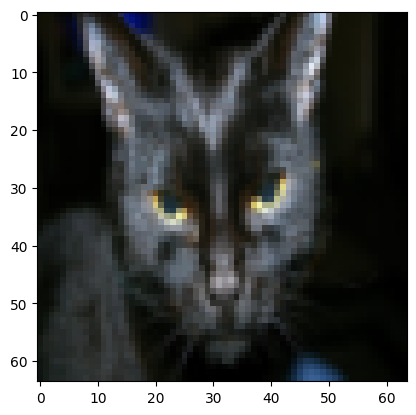

In [4]:
# Example of a picture
index = 25
plt.imshow(train_set_x_orig[index])
print("label: ", train_set_y[:, index])

### **Exercise 1:** Take a look at five different images in train/test set. Try to see both cat and non-cat samples.

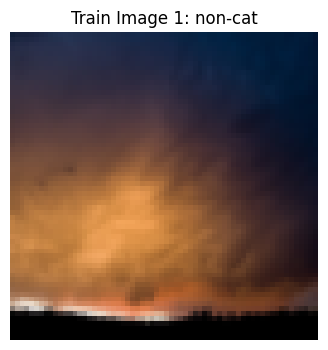

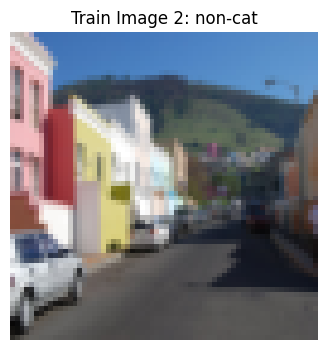

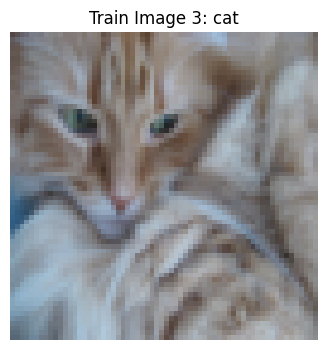

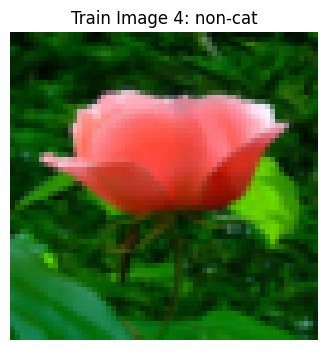

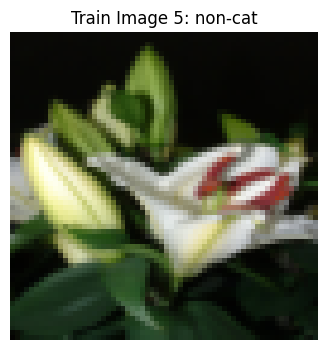

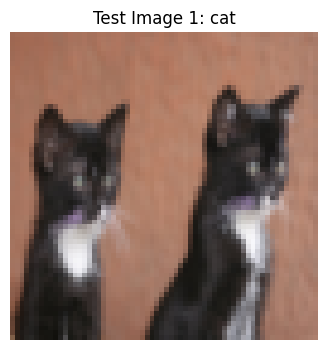

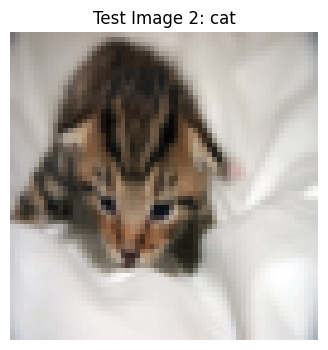

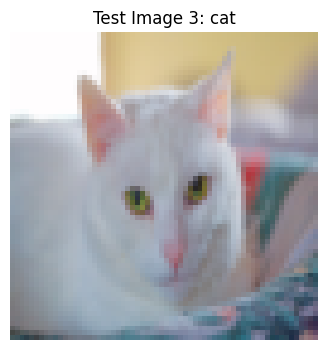

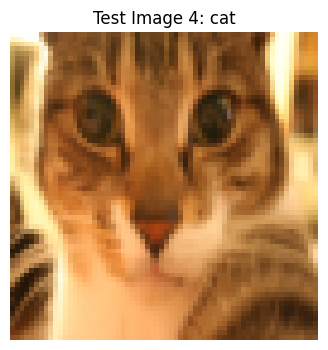

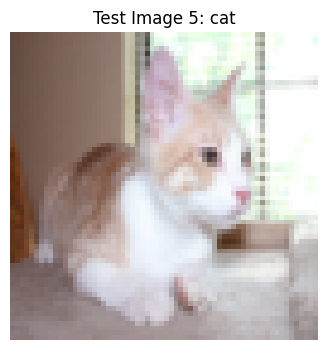

In [20]:
#your code here
for i in range(5):
    plt.figure(figsize=(4, 4))
    plt.imshow(train_set_x_orig[i])
    label = "cat" if train_set_y[0, i] == 1 else "non-cat"
    plt.title(f"Train Image {i+1}: {label}")
    plt.axis("off")
    plt.show()

for i in range(5):
    plt.figure(figsize=(4, 4))
    plt.imshow(test_set_x_orig[i])
    label = "cat" if test_set_y[0, i] == 1 else "non-cat"
    plt.title(f"Test Image {i+1}: {label}")
    plt.axis("off")
    plt.show()


### **Exercise 2:** What percentage of the pictures in `train set` contain cats?

In [21]:
# your code here
num_cats = np.sum(train_set_y == 1)
total_images = train_set_y.shape[1]
percentage_cats = (num_cats / total_images) * 100

print(f"Percentage of pictures in the train set containing cats: {percentage_cats:.2f}%")


Percentage of pictures in the train set containing cats: 34.45%


## Data Pre-processing

### Brief Theory: Numerical Representation of Images

![preprocessing](https://raw.githubusercontent.com/PyDataGBC/PyML2025/refs/heads/main/LabWeek2/assets/imvectorkiank.png)

### Simple Numerical Example

![](https://raw.githubusercontent.com/PyDataGBC/PyML2025/refs/heads/main/LabWeek2/assets/imtovec_example.webp)

#### Step 1: Numerical representation of each channel

In [7]:
red_channel = np.array([[255, 123, 135], [44, 12, 15], [56, 87, 90]]) # 2d array: Matrix
green_channel = np.array([[255, 133, 175], [24, 123, 169], [98, 66, 77]])
blue_channel = np.array([[66, 54, 88], [55, 98, 54], [87, 142, 89]])

print("Red Channel")
print(red_channel.shape)
print(red_channel)

print("Green Channel")
print(green_channel.shape)
print(green_channel)

print("Bue Channel")
print(blue_channel.shape)
print(blue_channel)



Red Channel
(3, 3)
[[255 123 135]
 [ 44  12  15]
 [ 56  87  90]]
Green Channel
(3, 3)
[[255 133 175]
 [ 24 123 169]
 [ 98  66  77]]
Bue Channel
(3, 3)
[[ 66  54  88]
 [ 55  98  54]
 [ 87 142  89]]


#### Step 2: Putting the channels together in the form of a tensor

In [8]:
print("channel, height, width")
airplane_image = np.array([red_channel, green_channel, blue_channel])  # 3d array: Tensor
print(airplane_image.shape)
print(airplane_image)

channel, height, width
(3, 3, 3)
[[[255 123 135]
  [ 44  12  15]
  [ 56  87  90]]

 [[255 133 175]
  [ 24 123 169]
  [ 98  66  77]]

 [[ 66  54  88]
  [ 55  98  54]
  [ 87 142  89]]]


#### Step 3: Flatten the tensor into a vector

In [9]:
airplane_flatten = airplane_image.flatten()   # 1d array: Vector
print(airplane_flatten.shape)
print(airplane_flatten)

(27,)
[255 123 135  44  12  15  56  87  90 255 133 175  24 123 169  98  66  77
  66  54  88  55  98  54  87 142  89]


### **Exercise 3:** Take one sample form train set again and check the shape of it. Try to interpret the numbers in the `shape`.

**Notes:**
- The images are 64x64 `pixels`.
- There are 3 RGB `channels`.

In [22]:
sample_index = 25
sample_image = train_set_x_orig[25]

#your code here
sample_index = 25
sample_image = train_set_x_orig[sample_index]
print(f"Shape of sample image: {sample_image.shape}")
print("The shape is (64, 64, 3), indicating a 64x64 image with 3 RGB color channels.")


Shape of sample image: (64, 64, 3)
The shape is (64, 64, 3), indicating a 64x64 image with 3 RGB color channels.


### Exercise 4: Fallaten the this sample image? what is the size of the flattened image? why this number?

In [23]:
sample_flatten = sample_image.flatten()
print(f"Shape of flattened sample image: {sample_flatten.shape}")
print("The size is 64 x 64 x 3 = 12288, which corresponds to the total number of pixels across all three color channels.")


Shape of flattened sample image: (12288,)
The size is 64 x 64 x 3 = 12288, which corresponds to the total number of pixels across all three color channels.


### Data Preprocessing: Flattening the entrie Train and Test Datasets

In [11]:
train_flat = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1)
print(train_flat.shape)

test_flat = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1)
print(test_flat.shape)

train_label = train_set_y[0]
print(train_label.shape)

test_label = test_set_y[0]
print(test_label.shape)



(209, 12288)
(50, 12288)
(209,)
(50,)


**Important Notes:**
- We have 209 samples in the train set, and
- 50 samples in the test set.
- each sample has 64x64x3=12288 `features`. So each pixel can be considered as one feature.
- remember that we had `4` features in `IRIS` dataset and now we have more than `10,000` features.

## Implementing Logistic Regression

![](https://raw.githubusercontent.com/PyDataGBC/PyML2025/refs/heads/main/LabWeek2/assets/LogReg_kiank.png)

### **Exercise 5:** Train a `LogisticRegression` classifier to run a binary classification on the flattened cat pictures.

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [24]:
#your code here

train_flat = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1)
test_flat = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1)


model = LogisticRegression(max_iter=1000)
model.fit(train_flat, train_set_y.ravel())


test_predictions = model.predict(test_flat)


### **Exercise 6:** Evaluate your model manually

1. Choose a random index of an image.
2. Display the image.
3. Print the original label.
4. Print the predicted label.
5. Repeat this process multiple times to identify which pictures are more challenging for the model.

### **Exercise 7:** Report the overall accuracy of your classifier.

In [26]:
#you code here
accuracy = accuracy_score(test_set_y.ravel(), test_predictions)
print(f"Overall accuracy of the Logistic Regression model: {accuracy:.2f}")


Overall accuracy of the Logistic Regression model: 0.66


## MNIST dataset (Optional)- Do exercise 8-10 if you have extra time to practise

In [15]:
#import mnist dataset
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
x_train.shape

(60000, 28, 28)

Label:  6
Image Shape:  (28, 28)


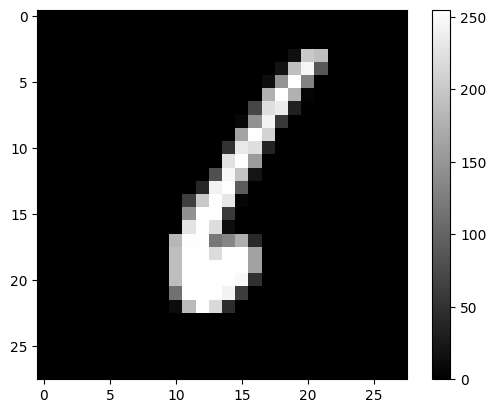

In [17]:
#Note: Run this cell multiple times
index = np.random.randint(0, x_train.shape[0])
print("Label: ", y_train[index])
print("Image Shape: ", x_train[index].shape)
plt.imshow(x_train[index], cmap='gray')
plt.colorbar()

### **Excercise 8:** What is the difference between a black-and-white image and a color image in terms of numerical representation?

### Hint: check the number of channels in the two types of images.

your answer here:

### **Exercise 9:** Select one data sample and flatten it. What is the size of the flattened image and why?

In [18]:
## your code here

### **Excercise 10:** Flatten the Entire Train and Test Datasets and implement a logistic regression model on MNIST dataset. What is the accuracy of your model?

In [19]:
##your code here

**Some food for thought:** What would the architecture of my model be if I used more than one neuron to predict the label?